## GAN template

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
image_channels = 3
hidden_dim = 256
num_epochs = 50
batch_size = 64
lr = 0.0002
beta1 = 0.5


In [47]:

# Generator Network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is latent_dim
            nn.Linear(latent_dim, hidden_dim * 4),
            nn.ReLU(True),

            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.ReLU(True),
            nn.BatchNorm1d(hidden_dim * 2),

            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(True),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, 28 * 28 * image_channels),
            nn.Tanh()
        )

    def forward(self, x):
        img = self.main(x)
        img = img.view(-1, image_channels, 28, 28)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Input is 28x28
            nn.Flatten(),
            nn.Linear(28 * 28 * image_channels, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [48]:

# Initialize networks and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [55]:

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64 (common for GANs)
    transforms.ToTensor(),       # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] for GANs
])


In [56]:

dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [57]:
for batch in dataloader:
    print("Batch shape:", batch[0].shape)  # Should be [batch_size, channels, height, width]
    break

Batch shape: torch.Size([64, 1, 64, 64])


In [58]:

# Training function
def train_gan():
    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Labels for real and fake images
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)

            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

            if i % 100 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')

        # Save generated images after each epoch
        if (epoch + 1) % 5 == 0:
            save_images(epoch + 1)


In [51]:

# Function to generate and save images
def save_images(epoch):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(16, latent_dim).to(device)
        fake_images = generator(noise)
        fake_images = fake_images.cpu().numpy()

        # Plot the fake images
        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i][0], cmap='gray')
            plt.axis('off')
        plt.savefig(f'fake_images_epoch_{epoch}.png')
        plt.close()
    generator.train()

# Function to generate new images after training
def generate_images(num_images=16):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim).to(device)
        fake_images = generator(noise)
        fake_images = fake_images.cpu().numpy()

        plt.figure(figsize=(4, 4))
        for i in range(num_images):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i][0], cmap='gray')
            plt.axis('off')
        plt.show()
    generator.train()


In [ ]:

# Main execution
if __name__ == "__main__":
    print("Starting GAN training...")
    train_gan()
    print("Training finished!")

    # Generate some images
    print("Generating sample images...")
    generate_images()

In [ ]:
import os

# Function to save the trained models
def save_models(generator, discriminator, epoch, g_optimizer, d_optimizer, save_dir='saved_models'):
    """
    Save both Generator and Discriminator states along with optimizers
    """
    os.makedirs(save_dir, exist_ok=True)

    state = {
        'generator_state': generator.state_dict(),
        'discriminator_state': discriminator.state_dict(),
        'g_optimizer_state': g_optimizer.state_dict(),
        'd_optimizer_state': d_optimizer.state_dict(),
        'epoch': epoch
    }

    torch.save(state, os.path.join(save_dir, f'gan_checkpoint_epoch_{epoch}.pth'))
    print(f"Model saved at epoch {epoch}")
save_models(generator, discriminator, 50, g_optimizer, d_optimizer)

Model saved at epoch 50


In [ ]:

# Function to load the trained models
def load_models(generator, discriminator, g_optimizer, d_optimizer, checkpoint_path):
    """
    Load saved model states
    """
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    generator.load_state_dict(checkpoint['generator_state'])
    discriminator.load_state_dict(checkpoint['discriminator_state'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state'])

    return checkpoint['epoch']


In [ ]:

# Function for inference using the trained generator
def generate_images_from_loaded_model(generator, num_images=16, latent_dim=100, device='cpu'):
    """
    Generate images using a loaded generator model
    """
    generator.eval()  # Set to evaluation mode
    with torch.no_grad():  # No need to calculate gradients for inference
        # Generate random noise
        noise = torch.randn(num_images, latent_dim).to(device)

        # Generate images
        fake_images = generator(noise)
        fake_images = fake_images.cpu().numpy()

        # Plot the generated images
        plt.figure(figsize=(4, 4))
        for i in range(num_images):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i][0], cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()


In [ ]:

# Example usage for saving during training
def train_gan():
    for epoch in range(num_epochs):
        # ... [previous training code remains the same] ...

        # Save model periodically (e.g., every 10 epochs)
        if (epoch + 1) % 10 == 0:
            save_models(generator, discriminator, epoch + 1, g_optimizer, d_optimizer)


In [ ]:

# Example of how to load and use the model for inference
def load_and_generate():
    # Initialize models and optimizers
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

    # Load the saved model
    checkpoint_path = 'saved_models/gan_checkpoint_epoch_50.pth'  # Adjust path as needed
    epoch = load_models(generator, discriminator, g_optimizer, d_optimizer, checkpoint_path)
    print(f"Loaded model from epoch {epoch}")

    # Generate images using the loaded model
    generate_images_from_loaded_model(generator, device=device)


<ipython-input-13-2e1dac7a8f9c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded model from epoch 50


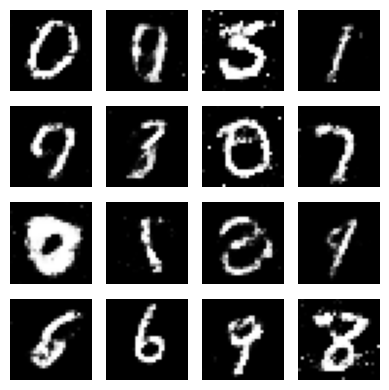

In [ ]:
load_and_generate()

In [ ]:

# Example of how to use these functions
if __name__ == "__main__":
    # For training and saving:
    train_gan()

    # For loading and generating images:
    load_and_generate()

## Celeb Face Generation with GAN

### Prepare environment

In [1]:
!pip install -qU datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### Prepare dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset("nielsr/CelebA-faces")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/202599 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 202599
    })
})

In [25]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218>}

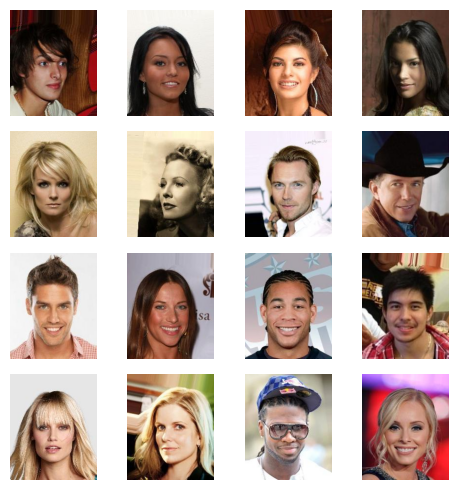

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def display_image_grid(dataset, num_images=16, rows=4, cols=4):
    """Displays a grid of images from the dataset."""
    fig, axes = plt.subplots(rows, cols, figsize=(5, 5))
    for i in range(num_images):
        row = i // cols
        col = i % cols
        image = dataset['train'][i]['image']
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()


display_image_grid(dataset)

In [61]:
import numpy as np

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Load the image
        image = self.hf_dataset[idx]["image"]
        if self.transform:
            image = self.transform(image)
        return image

# Wrap the train dataset
train_dataset = ImageDataset(dataset["train"], transform=transform)

# Create DataLoader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Example usage
for batch in dataloader:
    print("Batch shape:", batch.shape)  # Should be [batch_size, channels, height, width]
    break


Batch shape: torch.Size([64, 3, 64, 64])


In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
import torchvision.utils as vutils

latent_dim = 100
image_size = 28
image_channels = 3
hidden_dim = 64
num_epochs = 100
batch_size = 32
lr = 0.0002
beta1 = 0.5


In [98]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [99]:
def transform_images(examples):
    images = [transform(image) for image in examples['image']]
    return {'pixel_values': images}

# Apply transforms to dataset
transformed_dataset = dataset['train'].with_transform(transform_images)
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)


In [100]:
for batch in dataloader:
    print("Batch shape:", batch['pixel_values'].shape)  # Should be [batch_size, channels, height, width]
    break

Batch shape: torch.Size([32, 3, 28, 28])


### Generator & Discriminator

In [ ]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 7*7*256),
            nn.BatchNorm1d(7*7*256),
            nn.ReLU(True),

            nn.Unflatten(1, (256, 7, 7)),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, image_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).squeeze()


In [104]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(16, latent_dim).to(device)


### Training

In [105]:
import os
def train_gan():
    os.makedirs('checkpoints', exist_ok=True)
    os.makedirs('generations', exist_ok=True)

    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            real_images = batch['pixel_values']
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            real_labels = torch.ones(batch_size).to(device)
            fake_labels = torch.zeros(batch_size).to(device)

            # Train Discriminator
            d_optimizer.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)

            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

            if i % 1000 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                      f'd_loss: {d_loss.item():.4f} g_loss: {g_loss.item():.4f}')

        # Save generated images and model checkpoint
        # if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise)
            vutils.save_image(fake_images, f'generations/fake_faces_epoch_{epoch+1}.png',
                            normalize=True, nrow=4)
        torch.save({
            'generator_state': generator.state_dict(),
            'discriminator_state': discriminator.state_dict(),
            'g_optimizer_state': g_optimizer.state_dict(),
            'd_optimizer_state': d_optimizer.state_dict(),
            'epoch': epoch,
        }, f'checkpoints/face_gan_epoch_{epoch+1}.pth')
        print(f"generated image and checkpoint saved for epoch: {epoch + 1}")



In [106]:
train_gan()

Epoch [0/100] Batch [0/6332] d_loss: 1.3802 g_loss: 0.8449
Epoch [0/100] Batch [1000/6332] d_loss: 0.2777 g_loss: 3.9628
Epoch [0/100] Batch [2000/6332] d_loss: 0.4143 g_loss: 2.4989
Epoch [0/100] Batch [3000/6332] d_loss: 0.0648 g_loss: 7.3913
Epoch [0/100] Batch [4000/6332] d_loss: 0.0341 g_loss: 6.2374
Epoch [0/100] Batch [5000/6332] d_loss: 0.3566 g_loss: 3.9433
Epoch [0/100] Batch [6000/6332] d_loss: 0.0850 g_loss: 4.0718
generated image and checkpoint saved for epoch: 1
Epoch [1/100] Batch [0/6332] d_loss: 0.1676 g_loss: 4.1201
Epoch [1/100] Batch [1000/6332] d_loss: 0.2016 g_loss: 4.4270
Epoch [1/100] Batch [2000/6332] d_loss: 0.0925 g_loss: 4.2659
Epoch [1/100] Batch [3000/6332] d_loss: 0.0266 g_loss: 5.8433
Epoch [1/100] Batch [4000/6332] d_loss: 0.4192 g_loss: 3.9855
Epoch [1/100] Batch [5000/6332] d_loss: 0.1285 g_loss: 3.8789
Epoch [1/100] Batch [6000/6332] d_loss: 0.0550 g_loss: 6.0060
generated image and checkpoint saved for epoch: 2
Epoch [2/100] Batch [0/6332] d_loss: 0

KeyboardInterrupt: 

### Generations

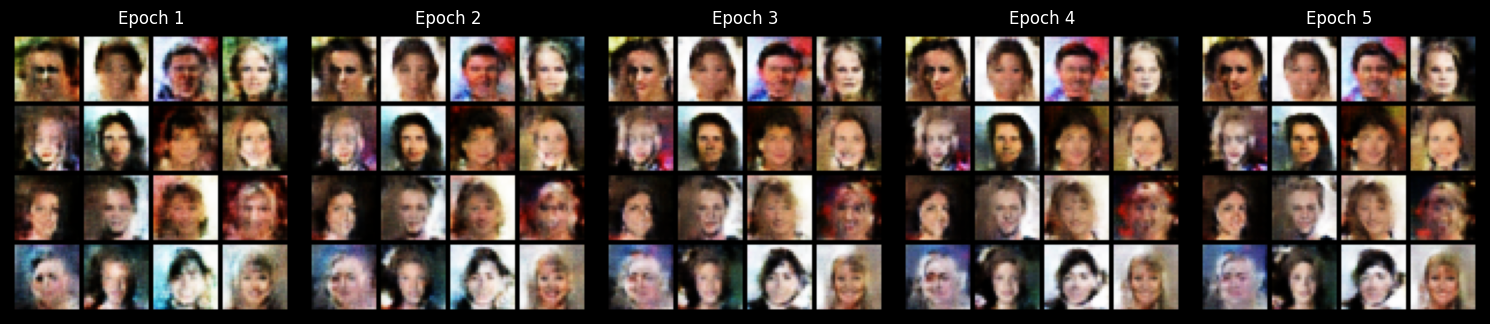

In [109]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

image_dir = 'generations'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.endswith('.png')]

# Sort the image files by epoch number, accounting for potential inconsistencies in file names
image_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
# Create a figure and axes for the images
fig, axes = plt.subplots(1, len(image_files), figsize=(15, 5))  # Adjust figure size as needed

# Display each image in a subplot
for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Epoch {image_file.split('_')[3].split('.')[0]}")  # Set title with epoch number

plt.tight_layout()
plt.show()